# Disease Type Classifier
- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

classify cancer type from gene expression

In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from keras.layers import Dense
from keras.layers import Dense,Input,BatchNormalization, InputLayer, Activation
from keras.models import Sequential
from keras.optimizers import Adam, SGD, Adadelta, Adagrad
from keras.regularizers import L1L2
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__ :
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)
from loadData import loadTumorNormalData

Using TensorFlow backend.


/home/ubuntu/BME-230a


In [2]:
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath) :
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush() # force error message to print
    raise ValueError(emsg)

/bme-230a-ebs/data/tcga_target_gtex.h5


In [3]:
%%time
# Load training set
XDF = pd.read_hdf(sourceDataFilePath, "expression")
print("XDF.shape:{}".format(XDF.shape))

yDF = pd.read_hdf(sourceDataFilePath, "labels")
print("yDF.shape:{} type(yDF):".format(yDF.shape)) 

XDF.shape:(19126, 58581)
yDF.shape:(19126, 7) type(yDF):
CPU times: user 144 ms, sys: 3.25 s, total: 3.4 s
Wall time: 3.39 s


In [4]:
XDF.head(1)

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966041,-9.965816,-9.965881,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.114,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658


In [5]:
yDF.head(1)

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal


In [6]:
np.array_equal(pd.unique( yDF.loc[:,"disease"] ), pd.unique( yDF.loc[:,"category"] ))

True

In [7]:
diseaseClasses = pd.unique( yDF.loc[:,"disease"] )
diseaseK = len(diseaseClasses)
print("diseaseK: {}, type(diseaseClasses): {}".format(diseaseK, type(diseaseClasses)))
print(diseaseClasses)

diseaseK: 93, type(diseaseClasses): <class 'numpy.ndarray'>
['Adipose - Subcutaneous' 'Muscle - Skeletal' 'Artery - Tibial'
 'Artery - Coronary' 'Heart - Atrial Appendage'
 'Adipose - Visceral (Omentum)' 'Ovary' 'Uterus' 'Breast - Mammary Tissue'
 'Minor Salivary Gland' 'Brain - Cortex' 'Adrenal Gland' 'Thyroid' 'Lung'
 'Pancreas' 'Esophagus - Muscularis' 'Esophagus - Mucosa' 'Stomach'
 'Skin - Not Sun Exposed (Suprapubic)' 'Colon - Sigmoid'
 'Small Intestine - Terminal Ileum' 'Colon - Transverse' 'Prostate'
 'Testis' 'Skin - Sun Exposed (Lower Leg)' 'Nerve - Tibial'
 'Heart - Left Ventricle' 'Spleen' 'Pituitary' 'Brain - Cerebellum'
 'Cells - Transformed Fibroblasts' 'Whole Blood'
 'Esophagus - Gastroesophageal Junction'
 'Cells - Ebv-Transformed Lymphocytes' 'Artery - Aorta' 'Vagina' 'Liver'
 'Brain - Substantia Nigra' 'Brain - Anterior Cingulate Cortex (Ba24)'
 'Brain - Frontal Cortex (Ba9)' 'Brain - Cerebellar Hemisphere'
 'Brain - Caudate (Basal Ganglia)'
 'Brain - Nucleus Accumbe

Text(0.5,1,'disease counts')

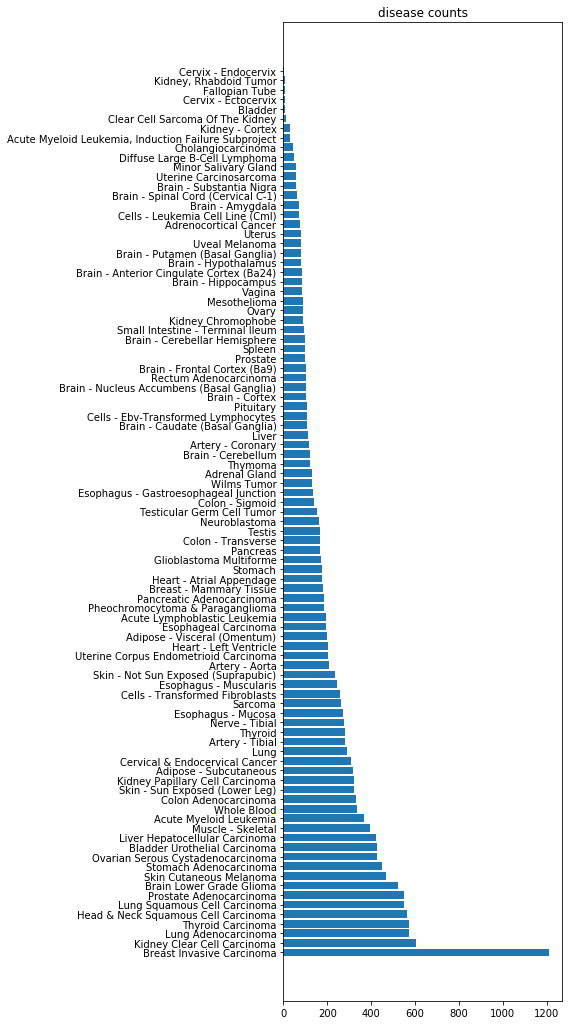

In [8]:
def plotCategoryCounts(df, colNameStr, ):
    '''
    TODO: make this more generic
    argument 
        df: a pandas data frame 
        colNameStr: 
        
    returns 
        (fig, ax)
    '''
    # countDF is series
    countDF = df[colNameStr].value_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(5,18)
    ax.barh(countDF.index, countDF)    
    
    return (fig, ax)

fig, ax = plotCategoryCounts(yDF, "disease")
ax.set_title("disease counts")

## Prepare data

TODO simple classifier on 93 classes -> Trainable params: 5,565,288 and takes 9min 26s to train. Try select most frequent classes

In [9]:
# Convert disease  into numerical values 
encoder = LabelEncoder()
yDF["disease_value"] = pd.Series(encoder.fit_transform(yDF["disease"]), index=yDF.index)

In [10]:
# create one hot encodings

oneHots = np_utils.to_categorical(yDF["disease_value"])
print(type(oneHots))
print(oneHots.shape)

diseaseValues = yDF["disease_value"].values.reshape(yDF.shape[0],-1)
print(type(diseaseValues))
print(diseaseValues.shape)

yOneHots = np.append(diseaseValues, oneHots, axis=1)
print(type(yOneHots))
print(yOneHots.shape)

<class 'numpy.ndarray'>
(19126, 93)
<class 'numpy.ndarray'>
(19126, 1)
<class 'numpy.ndarray'>
(19126, 94)


In [11]:
%%time
# Split into stratified training and test sets based on classes (i.e. 
# disease type) so that we have equal proportions of each disease type 
# in the train and test sets
  
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=theMeaningOfLife)
for train_index, test_index in split.split(XDF.values, yDF["disease_value"]):
    XTrainNumpy = XDF.values[train_index]
    XTestNumpy  =  XDF.values[test_index]
    yTrainNumpy = yOneHots[train_index]
    yTestNumpy  = yOneHots[test_index]
    
print("XTrainNumpy.shape: {} XTestNumpy.shape: {}".format(XTrainNumpy.shape, XTestNumpy.shape))
# pandas series values attribute create numpy arrays with shapes that are under specified
# E.G. yTestNumpy.shape: (3826,) .this causes a lot of bugs in other packages
# reshape(n,-1) causes reshape to set the last value
yTrainNumpy = np.reshape(yTrainNumpy,(yTrainNumpy.shape[0], -1))
yTestNumpy  = np.reshape( yTestNumpy, (yTestNumpy.shape[0], -1))
print("yTrainNumpy.shape: {} yTestNumpy.shape: {}".format(yTrainNumpy.shape, yTestNumpy.shape))
print(type(yTestNumpy))

XTrainNumpy.shape: (15300, 58581) XTestNumpy.shape: (3826, 58581)
yTrainNumpy.shape: (15300, 94) yTestNumpy.shape: (3826, 94)
<class 'numpy.ndarray'>
CPU times: user 988 ms, sys: 7.86 s, total: 8.85 s
Wall time: 8.87 s


In [12]:
yTrainNumpy[0:2]
# xxx = yTrainNumpy[:,1:]
# xxx[0:2]

array([[75.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,

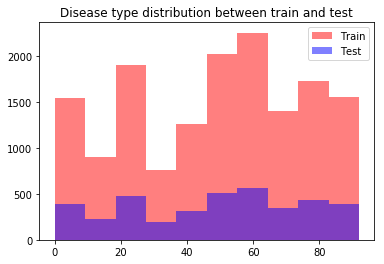

In [13]:
# check class sizes
# [:.0] is disease_value column
plt.hist(yTrainNumpy[:,0], alpha=0.5, label='Train', color="red")
plt.hist(yTestNumpy[:,0],   alpha=0.5, label='Test', color="blue")
plt.legend(loc='upper right')
plt.title("Disease type distribution between train and test")
plt.show()

## Create Model

In [14]:
def multiClassClassifier(inputDim=None, outputDim=None, learningRate=0.001):
    '''
    aedwip
    '''
    classify = [
        InputLayer(input_shape=(inputDim,)),
        BatchNormalization(),
        Dense(outputDim), # dot(input, kernel) + bias
        Activation('softmax') 
    ]
    
    model = Sequential(classify)   
    # https://keras.io/backend/#categorical_crossentropy
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learningRate), metrics=['accuracy']) 
    
    return model 

In [15]:
%%time
modelName="diseaseClassifier"
diseaseClassifierModel = multiClassClassifier(
                                inputDim=XTrainNumpy.shape[1],
                                outputDim=diseaseK,
                                )
diseaseClassifierModel.summary()

# https://keras.io/callbacks/
checkPointPath="./models/{}.chkPt".format(modelName)
callbacks = [
    # monitor valuse either 'acc' for accuracy or 'loss'
    # 'val_loss' is loss on hold if valaidation_split is set
    # 'loss' is loss on training
    # same for 'acc' and 'val_acc'
    EarlyStopping(monitor='loss', patience=2, verbose=0) 
    ,ModelCheckpoint(checkPointPath, monitor='loss', save_best_only=False, verbose=0)
    # FIXME: progbar generates run time error
    #,ProgbarLogger(count_mode='samples', stateful_metrics=None)
]

trainOneHots = yTrainNumpy[:,1:]
history = diseaseClassifierModel.fit(XTrainNumpy,trainOneHots,        
                                        shuffle=None, # we already shuffled
                                        epochs= 8, #20, #100
                                        batch_size=1024, 
                                        # we already split the data         
                                        validation_split=0.0, 
                                        verbose=0,
                                        callbacks=callbacks
                                     )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 93)                5448126   
_________________________________________________________________
activation_1 (Activation)    (None, 93)                0         
Total params: 5,682,450
Trainable params: 5,565,288
Non-trainable params: 117,162
_________________________________________________________________
CPU times: user 4min 3s, sys: 1min 24s, total: 5min 28s
Wall time: 2min 20s


In [16]:
def calculateAccuracy(model, X, y):
    '''
    calculates accuracy

    arguments
        model: 
            a keras model that returns the output of softmax
        
        X:
            the set of data to make prediction on. Types must be numpy array
        y:
            the expected values, a numpy array with shape (n, 1) of values. Do not pass one hots
    
    returns float
    '''
    # predictions is output of softmax layer
    predictions = diseaseClassifierModel.predict(X)
    predictedValuesTensor = keras.backend.argmax(predictions)
    
    # use keras escape hatch to tensor flow
    sess = tf.Session()
    with sess.as_default():
        predictedValuesNumpy = predictedValuesTensor.eval()

    indicators = np.equal(predictedValuesNumpy, y)
    accuracy = np.sum(indicators) / len(indicators)
    
    return accuracy

In [17]:
%%time
trainAcc = calculateAccuracy( diseaseClassifierModel, XTrainNumpy, yTrainNumpy[:,0] )
testAcc  = calculateAccuracy( diseaseClassifierModel, XTestNumpy,   yTestNumpy[:,0] )
print("training accuracy:{}".format(trainAcc))
print("    test accuracy:{}".format(testAcc))

training accuracy:0.982875816993464
    test accuracy:0.9281233664401464
CPU times: user 33.1 s, sys: 2.83 s, total: 35.9 s
Wall time: 8.94 s


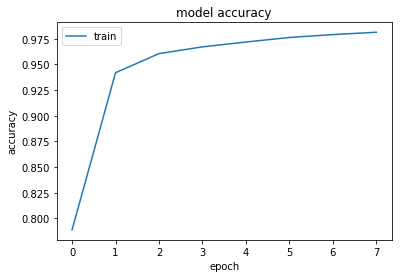

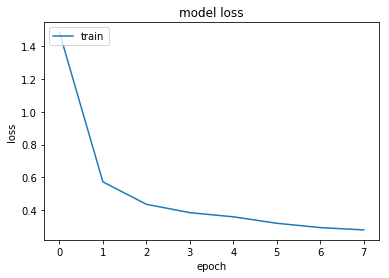

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# save model
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/full{}.h5".format(modelRootDir, modelName)

if not os.path.exists(modelRootDir):
    print("create modle directory:{}".format(modelRootDir))
    os.makedirs(modelRootDir)

if not os.path.isfile(fullModelPath):
    diseaseClassifierModel.save(fullModelPath)
    print("Saved {} to disk".format(fullModelPath))
else:
    print("ERROR: model was not save. files already exist {}".format(fullModelPath))

ERROR: model was not save. files already exist /bme-230a-ebs/models/fulldiseaseClassifier.h5
